# IMU noise characterization

Three different approaches;
- historgram
- custom Allan deviation
- using allan tools
Familiarity with the IEEE Standard 952 as well as with the nomenclature commonly used, the various units, etc, is helpful.

In [1]:
%matplotlib inline
# plot the gyroscope historgram for few seconds of data
# https://stackoverflow.com/questions/29208440/fit-a-distribution-to-a-histogram
# https://stackoverflow.com/questions/70164620/how-to-gaussian-fit-histogram
# For gyro input in rad/s, the FWHM will be in rad/s
# TODO find relation between sigma and FWHM
import os # for file manipulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats

HOME = os.getenv("HOME")
#CSV_FILENAME = 'imu_oakdpro_1hr_28032024.csv'
CSV_FILENAME = HOME+'/Data/Drones/IMU/imu_oak_BNO086_2hr_02042024.csv'
FS = 100  # Sample rate [Hz]
NOISE_PARAM_UNIT = 'rad'
PRECI= 2
TYPE = "e" # e: exponential notation
TS = 1.0 / FS
NB_SAMPLE = 1000 # nb of samples to take from the input data (csv file)
DEG_2_RAD = np.pi / 180.0
RAD_2_DEG = 180.0 / np.pi


The angular rate sensor is described by the quantities $N$ (angle random walk), $B$ (bias instability) and $K$ (rate random walk) from the IEEE Std 952. The values prescribed here approximate the properties of a Bosch SMI130 yaw rate sensor.

In [2]:
N = 5e-3 # °/sqrt(s) = 0.3 °/sqrt(h)
B = 7e-4 # °/s = 2.5 °/h
K = 6e-6 # °/s/sqrt(s)

Define the sampling rate ``fs`` and initialize noise sources:

In [2]:
# functions
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]


In [3]:
# Load CSV into np array
dataArr = np.genfromtxt(CSV_FILENAME, delimiter=',')

# Separate into arrays and select a slice of the input data
acc_ts = dataArr[:NB_SAMPLE, 0]  # time stamp for acceleration, second
accx = dataArr[:NB_SAMPLE, 1]  # m/s²
accy = dataArr[:NB_SAMPLE, 2]
accz = dataArr[:NB_SAMPLE, 3]
ts = dataArr[:NB_SAMPLE, 4]  # time stamp, second
gx = dataArr[:NB_SAMPLE, 5]  # (rad/s)
gy = dataArr[:NB_SAMPLE, 6]
gz = dataArr[:NB_SAMPLE, 7]


Now create an artifical sensor noise signal $w_{noise}$ from the individual noise sources denoted by $\xi$. The noise is additive and the coefficients $N$, $B$ and $K$ from the IEEE Std 952 enter as follows:

$$w_{noise} = N\xi_{white} + \frac{B}{\sqrt{2\pi}}\xi_{pink} + \frac{K}{2\pi}\xi_{red}$$

bins from histo: (array([-0.017044  , -0.01594323, -0.01484247, -0.0137417 , -0.01264093,
       -0.01154017, -0.0104394 , -0.00933863, -0.00823787, -0.0071371 ,
       -0.00603633, -0.00493557, -0.0038348 , -0.00273403, -0.00163327,
       -0.0005325 ,  0.00056827,  0.00166903,  0.0027698 ,  0.00387057,
        0.00497133,  0.0060721 ,  0.00717287,  0.00827363,  0.0093744 ,
        0.01047517,  0.01157593,  0.0126767 ,  0.01377747,  0.01487823,
        0.015979  ]), array([-0.017044  , -0.01594323, -0.01484247, -0.0137417 , -0.01264093,
       -0.01154017, -0.0104394 , -0.00933863, -0.00823787, -0.0071371 ,
       -0.00603633, -0.00493557, -0.0038348 , -0.00273403, -0.00163327,
       -0.0005325 ,  0.00056827,  0.00166903,  0.0027698 ,  0.00387057,
        0.00497133,  0.0060721 ,  0.00717287,  0.00827363,  0.0093744 ,
        0.01047517,  0.01157593,  0.0126767 ,  0.01377747,  0.01487823,
        0.015979  ]), array([-0.017044  , -0.01594323, -0.01484247, -0.0137417 , -0.01264093,
  

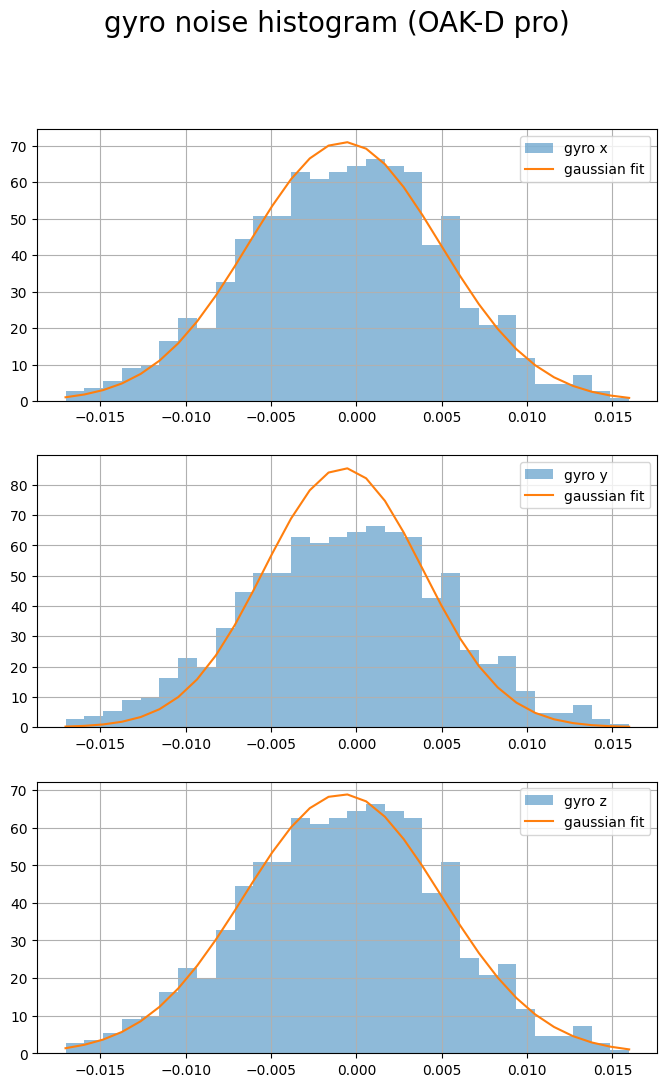

In [11]:
#
nbbins = 30
f, axarr = plt.subplots(3, sharex=False)
f.set_figheight(12)
f.set_figwidth(8)
f.suptitle(f'gyro noise histogram (OAK-D pro)',fontsize = 20)
#axarr[0].plot(t, accX_ref, 'y.',label="ground truth AccX")
_, bins_gx, _ = axarr[0].hist(gx, nbbins, density=1, alpha=0.5,label='gyro x')
_, bins_gy, _ = axarr[1].hist(gx, nbbins, density=1, alpha=0.5,label='gyro y')
_, bins_gz, _ = axarr[2].hist(gx, nbbins, density=1, alpha=0.5,label='gyro z')

#    axarr[0].plot(t, accX_best, "r-", label="best sensor")
#    axarr[0].plot(t, accX_good, "b-", label="good sensor")
#    axarr[0].plot(t, accX_worst, "g--", label="worst sensor")
# axarr[0].set_title('Gyro Angular rate X')
axarr[0].grid()
axarr[1].grid()
axarr[2].grid()
print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
mu, sigma = zip(stats.norm.fit(gx),stats.norm.fit(gy),stats.norm.fit(gz))

print(f'Gaussian best fit mu, sigma = {mu,sigma}')
gauss_fit_gx = stats.norm.pdf(bins_gx, mu[0], sigma[0])
gauss_fit_gy = stats.norm.pdf(bins_gy, mu[1], sigma[1])
gauss_fit_gz = stats.norm.pdf(bins_gz, mu[2], sigma[2])
axarr[0].plot(bins_gx,gauss_fit_gx,label = 'gaussian fit')
axarr[1].plot(bins_gy,gauss_fit_gy,label = 'gaussian fit')
axarr[2].plot(bins_gz,gauss_fit_gz,label = 'gaussian fit')

hmx = half_max_x(bins_gx,gauss_fit_gx)

axarr[0].legend()
axarr[1].legend()
axarr[2].legend()
#axarr[0].set_ylim([-2, 2])

In [5]:
# histogram analysis : accelerometer
_, bins_accx, _ = plt.hist(accx, 20, density=1, alpha=0.5)
_, bins_accy, _ = plt.hist(accy, 20, density=1, alpha=0.5)
_, bins_accz, _ = plt.hist(accz, 20, density=1, alpha=0.5)

_, bins_gx, _ = plt.hist(gx, 20, density=1, alpha=0.5)
_, bins_gy, _ = plt.hist(gy, 20, density=1, alpha=0.5)
_, bins_gz, _ = plt.hist(gz, 20, density=1, alpha=0.5)
print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
mu, sigma = zip(stats.norm.fit(gx),stats.norm.fit(gy),stats.norm.fit(gz))

print(f'Gaussian best fit mu, sigma = {mu,sigma}')
best_fit_line = stats.norm.pdf(bins_gx, mu[0], sigma[0])
# plt.plot(bins_gx, best_fit_line)
#x = gx.index.values
#y = np.array(gx['ABC'])
print(f'best_fit_line = {best_fit_line}')
x = bins_gx
#x = np.arange(len(gx))
#hmx = half_max_x(bins,gx) #x,y)
hmx = half_max_x(bins_gx,best_fit_line) #x,y)
#hmx = half_max_x(ts,gx) #x,y)
fwhm = (hmx[1] - hmx[0]) # 
print(f'FWHM = {fwhm:.{PRECI}}{NOISE_PARAM_UNIT}/s, hmx = {hmx}')

plt.plot([hmx[0],hmx[0]], [0,50])
plt.plot([hmx[1],hmx[1]], [0,50])
f, axarr = plt.subplots(3, sharex=True)
f.set_figheight(12)
f.set_figwidth(8)
f.suptitle(f'gyro noise histogram (OAK-D pro)',fontsize = 20)
#axarr[0].plot(t, accX_ref, 'y.',label="ground truth AccX")
_, bins, _ = axarr[0].hist(gx, 20, density=1, alpha=0.5)
#    axarr[0].plot(t, accX_best, "r-", label="best sensor")
#    axarr[0].plot(t, accX_good, "b-", label="good sensor")
#    axarr[0].plot(t, accX_worst, "g--", label="worst sensor")
axarr[0].set_title('Gyro Angular rate X')
axarr[0].grid()
axarr[0].legend()
#axarr[0].set_ylim([-2, 2])

plt.show()


Now calculate the Allan variance. The module ``allan`` is not provided by ``pyplnoise``, but many similar codes can be found on pypi.

In [6]:
tau, avar, adev, error_adev_pct = allan.allan_variance(w, dt=1./fs, n_clusters=8000,
                                                       verbose=False)

In [7]:
# omit values with insufficient statistical quality
idx_valid = error_adev_pct < 10
avar_valid = avar[idx_valid]
adev_valid = adev[idx_valid]
tau_valid = tau[idx_valid]

Here's how the calculated Allan deviation looks like.

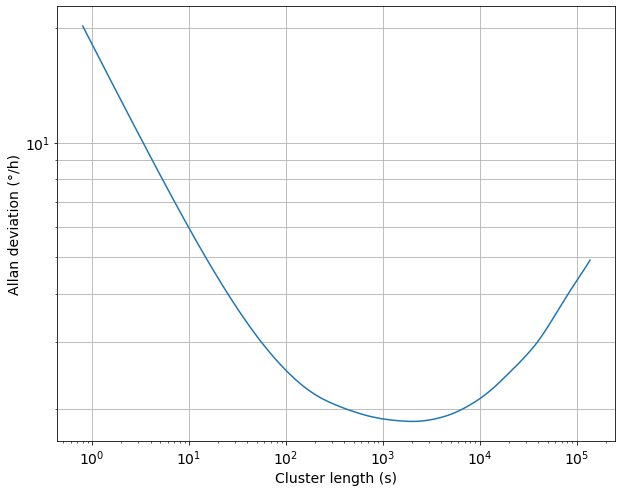

In [15]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax.loglog(tau_valid, adev_valid*3600)
ax.set_xlabel("Cluster length (s)")
ax.set_ylabel("Allan deviation (°/h)")
ax.grid(True, which='major')
ax.grid(True, which='minor', axis='y')

Let's extract the properties $N$, $B$ and $K$ automatically:

In [9]:
noise_density, a_n_fit, b_n_fit = allan.read_noise_density(adev_valid, tau_valid)
print("Extracted angle random walk: N = {:.4g} °/s/sqrt(Hz) = {:.5f} °/sqrt(h)"
      .format(noise_density, noise_density*60))
bias_instability = allan.read_bias_instability(adev_valid, tau_valid)
print("Extracted bias instability: B = {:.4g} °/s = {:.5f} °/h"
      .format(bias_instability, bias_instability*3600))
rate_random_walk, a_k_fit, b_k_fit = allan.read_rate_random_walk(adev_valid, tau_valid)
print("Extracted rate random walk: K = {:.4g} °/s^(3/2) = {:.5f} °/h^(3/2)"
      .format(rate_random_walk, rate_random_walk*3600**(3/2)))

Extracted angle random walk: N = 0.005027 °/s/sqrt(Hz) = 0.30159 °/sqrt(h)
Extracted bias instability: B = 0.0007754 °/s = 2.79154 °/h
Extracted rate random walk: K = 6.792e-06 °/s^(3/2) = 1.46705 °/h^(3/2)


If you rather prefer to find these values manually, you can read off the value of the red line at $\tau = 1$ to get $N$. The value of the green line at $\tau = 3$ is equal to $K$, and multiplication of the global minimum by $\sqrt{\frac{\pi}{2\ln 2}}\approx1/0.664$ yields $B$.

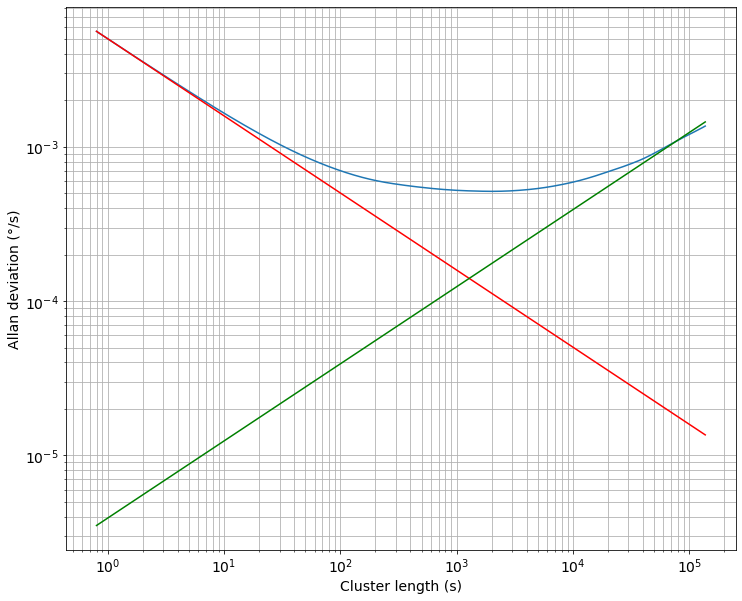

In [16]:
fit_vals_n = np.power(10.0, a_n_fit * np.log10(tau_valid) + b_n_fit)
fit_vals_k = np.power(10.0, a_k_fit * np.log10(tau_valid) + b_k_fit)
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
ax.loglog(tau_valid, adev_valid)
ax.loglog(tau_valid, fit_vals_n, color='red')
ax.loglog(tau_valid, fit_vals_k, color='green')
ax.set_xlabel("Cluster length (s)")
ax.set_ylabel("Allan deviation (°/s)")
ax.grid(True, which='both')